# Homework 4 Word2vec

In [2]:
import pandas as pd
import numpy as np # numpy-1.24.2  
import matplotlib.pyplot as plt
import string
from collections import Counter, OrderedDict
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import math
import random
from typing import List, Dict, Tuple 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Word2vec in multiple languages

we will be coding a word2vec model using an english and a small russian parallel text corpus. The goal is to understand how a very simple word embedding functions and how one might begin using them to investigate machine translation. 


### Load data

a subset of the multi-lingual text corpus from [Helsinki-NLP/Tatoeba-Challenge](https://github.com/Helsinki-NLP/Tatoeba-Challenge)

The subset is a partial copy of the bilingual Russian-English, English-Finnish, and Finnish-Russian parts of the corpus. 

In [3]:
!pwd 

/Users/wenxinxu/Desktop/CPSC557_NLP/hw/HW4word2vec


In [4]:
# Finnish and Russian parallel corpora
loc = '/Users/wenxinxu/Desktop/CPSC557_NLP/hw/data'
finrus = pd.read_csv(loc+'/finrus.csv', index_col=0)
# English and Russian parallel corpora
engrus = pd.read_csv(loc+'/engrus.csv', index_col=0)
# English and Finnish parallel corpora
engfin = pd.read_csv(loc+'/engfin.csv', index_col=0)

### 0) First Look
Take a look at some of the data. Print out a few sentence pairs, show a histogram of sentence lengths for each of the languages, etc. 

In [ ]:
### type code here ###

In [6]:
finrus.shape, engrus.shape, engfin.shape

((2500, 2), (2500, 2), (2500, 2))

In [7]:
finrus 

,finnish,russian
0,Perun kysymykseni.,Веселитесь.
1,- Häivytään.,Мы должны идти.
2,Sinä saavuit.,"Ах, детектив, ты сделала это."
3,U-veneistä ja siiloista laukaistut ohjukset tu...,Первая: запустим из вертикальной шахты ракету ...
4,Ei ole kenttää.,Здесь нет сигнала.
...,...,...
2495,-Miten?,"По сути, ""Калейдоскоп"" - это грандиозная много..."
2496,Hän toi minut kotiin ja palasi pyrkimään johon...,Хорошо. Моя подруга Шондел убита этим вечером.
2497,"Suosittelen sellaisen ostoa, jollet menettänyt...",Имя Терри должно быть на этой стене.
2498,Onko kaikki hyvin?,Это дом?


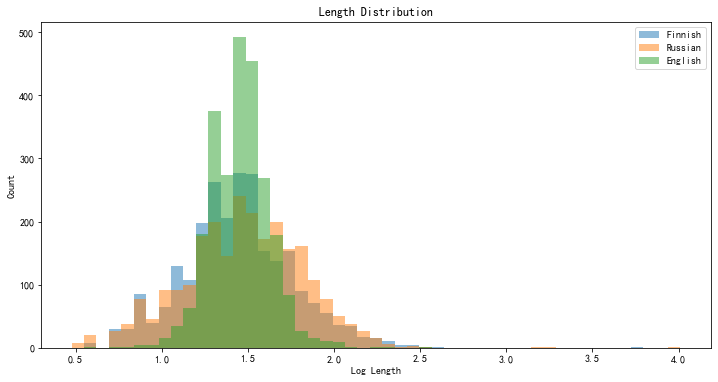

In [22]:
# Calculate log lengths
loglengths = [df.apply(lambda x: np.log10(len(x))) for df in [finrus['finnish'], finrus['russian'], engrus['english']]]
labels = ['Finnish', 'Russian', 'English']

# Calculate min and max log lengths
min_len = min([l.min() for l in loglengths])
max_len = max([l.max() for l in loglengths])

# Create bins
num_bins = 50
bins = np.linspace(min_len, max_len, num_bins)

plt.figure(figsize=(12, 6))

for loglength, label in zip(loglengths, labels):
    plt.hist(loglength, bins=bins, alpha=0.5, label=label)

plt.title('Length Distribution')
plt.xlabel('Log Length')
plt.ylabel('Count')
plt.legend()
plt.show()


the length distribution of 3 languages are all right skewed, English has longer sentence than other 2 langauge, average length is 35.

### 1) Preprocessing

We will be building a skip-gram word2vec embedding using this corpus. 

Our first step is to preprocess the text. 

The end results of preprocessing can be slightly different, but here we want to at least do these 4 steps.

1) tokenize

2) lowercase

3) remove punctuation

4) remove stop words (this step will be done in part 3 of the homework, do not include in your 'preprocess_sentence' function)

Make a single function to preprocess all of our English, Finnish, and Russian text.

In [87]:
# nltk.download('punkt')
# nltk.download('stopwords')

stop_words_eng = set(stopwords.words('english')) # 179 tokens
stop_words_fin = set(stopwords.words('finnish')) # 229 tokens
stop_words_rus = set(stopwords.words('russian')) # 151 tokens

def preprocess_sentence(text: str, language: str):
    # Tokenize
    words = word_tokenize(text)
    
    # Lowercase
    words = [word.lower() for word in words]
    
    # Remove punctuation
    words = [word for word in words if word not in string.punctuation]
    
    # Remove stopwords
    if language == 'english':
        words = [word for word in words if word not in stop_words_eng]
    elif language == 'finnish':
        words = [word for word in words if word not in stop_words_fin]
    elif language == 'russian':
        words = [word for word in words if word not in stop_words_rus]
    else:
        raise ValueError("Unsupported language")
    
    return words


Now preprocess all of our russian and english sentences.

In [88]:
pp_eng2fin = [preprocess_sentence(sentence, 'english') for sentence in engfin['english']]
pp_eng2rus = [preprocess_sentence(sentence, 'english') for sentence in engrus['english']]
pp_fin2eng = [preprocess_sentence(sentence, 'finnish') for sentence in engfin['finnish']]
pp_fin2rus = [preprocess_sentence(sentence, 'finnish') for sentence in finrus['finnish']]
pp_rus2eng = [preprocess_sentence(sentence, 'russian') for sentence in engrus['russian']]
pp_rus2fin = [preprocess_sentence(sentence, 'russian') for sentence in finrus['russian']]

### 2) One-hot-encode

The next step is to one-hot-encode our text corpora.

To do this, first begin by creating a vocabulary for each of our languages.

There can be many ways to do this, but the outcome should have the format of a dictionary where the key is the word and the value is an int unique to that language.

Also in this function, produce a separate dictionary, for token counts consisting of a dictionary with {key, count}. This will be used to remove stopwords and later for negative sampling.

Hint: allow your function to take in 2 sets of preprocessed text so that it can create a vocabulary for all of the text from a given language. 

Example: english vocabulary should include words from eng-rus and eng-fin.

In [89]:

def create_vocabulary(corpus1: List[List], corpus2: List[List]) -> Tuple[Dict, Dict]:
    ### type code here ###
    all_words = [word for word_list in corpus1+corpus2 for word in word_list]
    token_counts = dict(Counter(all_words))
    # Create an OrderedDict from the sorted token counts
    ordered_token_counts = OrderedDict(sorted(token_counts.items(), key=lambda x: -x[1]))
    vocabulary = {word: i for i, word in enumerate(ordered_token_counts)}

    return vocabulary, ordered_token_counts

vocabulary_english, token_counts_english = create_vocabulary(pp_eng2fin, pp_eng2rus)
print('english vocabulary length:',len(vocabulary_english))

vocabulary_finnish, token_counts_finnish = create_vocabulary(pp_fin2eng, pp_fin2rus)
print('english vocabulary length:',len(vocabulary_finnish))

vocabulary_russian, token_counts_russian = create_vocabulary(pp_rus2eng, pp_rus2fin)
print('russian vocabulary length:',len(vocabulary_russian))

english vocabulary length: 3588
english vocabulary length: 9284
russian vocabulary length: 9036


Then, write a function using the vocabularies to one-hot-encode single words.

In [136]:
def onehotencode(batch_word_idx, vocabulary):
    ### type code here ###
    one_hot = torch.zeros((len(batch_word_idx), len(vocabulary)), dtype=torch.long)
    for i, word_idx in enumerate(batch_word_idx):
        one_hot[i, word_idx] = 1
    return one_hot 

### 3) Zipf's law
Provide 3 plots, one for each of our corpora, to indicate whether they follow Zipf's law.

Then, using your plots, make a judgement call on where to threshold each of your vocabularies where high-frequency words will be considered stopwords. 

Then, filter out all of the stopwords from the preprocessed sentences: pp_eng2fin, pp_eng2rus, pp_fin2eng, pp_fin2rus, pp_rus2eng, and pp_rus2fin.

- Zipf's Law in Natural Language

    $$Rank \times Frequency \approx 0.1 \times len(text)$$

    product of a word's rank and frequency is approximately a constant equal to 0.1 times the length of text (in words).

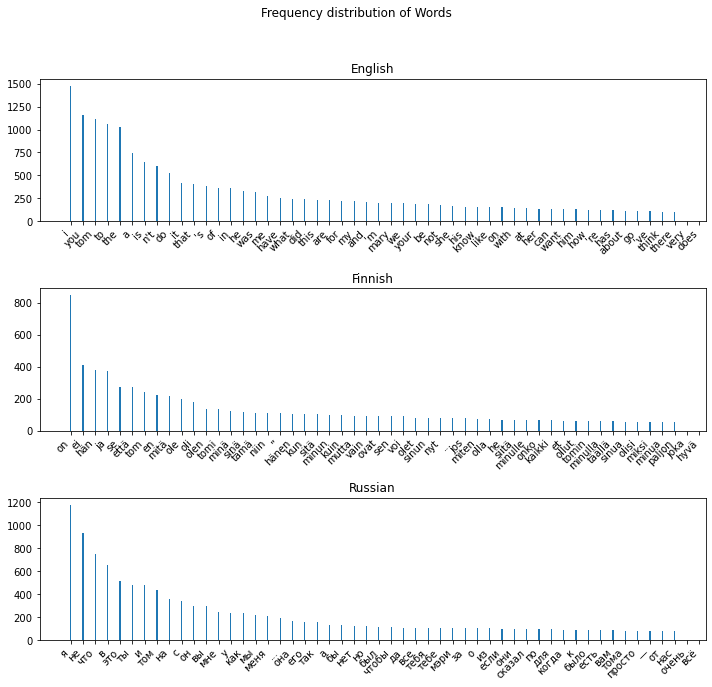

In [70]:
threshold = 50
# plot word frequencies
from matplotlib.ticker import FixedLocator
plt.rc("font", family="DejaVu Sans")

token_counts = [token_counts_english, token_counts_finnish, token_counts_russian]
titles = [ 'English', 'Finnish', 'Russian']

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for ax, token_count, title in zip(axs.flatten(), token_counts, titles): 
    ax.bar(list(token_count.keys())[:threshold], list(token_count.values())[:threshold], width=0.1)
    ax.xaxis.set_major_locator(FixedLocator(range(len(token_count))))
    ax.set_xticklabels(token_count.keys(), rotation=45, ha='right')
    ax.set_title(title)

plt.suptitle('Frequency distribution of Words')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to accommodate the suptitle
plt.show()


Examples of stop words in English include "the", "is", "in", "and", "on", "of", and "for". Because they appear frequently in text but don't provide much information about the content or topic, removing them can help focus on more meaningful words.

Stop words can vary between languages, and their selection might be subjective or based on the specific needs of a given project. There are many predefined lists of stop words for different languages, but you can also create your own list based on your requirements.

In [76]:
# filter out stop words
### type code here ###
vocabulary_english = {word: idx for idx, word in enumerate(list(vocabulary_english)[threshold:])}
vocabulary_finnish = {word: idx for idx, word in enumerate(list(vocabulary_finnish)[threshold:])}
vocabulary_russian = {word: idx for idx, word in enumerate(list(vocabulary_russian)[threshold:])}

### 4) Generate training data

Our training data will consist of pairs of word and contexts (target, [context1, context2, ...]). 
The contexts for a given word are generated using the skip-gram model.
Here, generate these training data where x is a list of the target words.

The window size refers to the distance we look to generate the skip gram.
For the sentence "Apricots are the most delicious fruit." and a window size of 2, the skip-grams for the target word "delicious" would be [(delicious, the), (delicious, most), (delicious, fruit)]. In this example stop words are not removed, this is not the case in the homework.

Hint: a single target word can have multiple context words within a skipgram model.

Hint: for each language, make sure to pass in all sentences for that language. Example, there are 5000 english sentences in the engfin corpus and 5000 english sentences in the russian corpus, thus it should include 10000 sentences. 

In [90]:
def generate_training_data(corpus1, corpus2, vocabulary, window_size):
    x = []
    y = []

    for sentence in (corpus1 + corpus2):
        for target_index, target_word in enumerate(sentence):
            # Ensure the target word is in the vocabulary
            if target_word not in vocabulary:
                continue

            # Get the context words within the window
            context_start = max(0, target_index - window_size)
            context_end = min(len(sentence), target_index + window_size + 1)

            for context_index, context_word in enumerate(sentence[context_start:context_end]):
                # Skip the target word itself and Ensure the context word is in the vocabulary
                if (context_index + context_start == target_index) or context_word not in vocabulary:
                    continue
                x.append(vocabulary[target_word])
                y.append(vocabulary[context_word])

    return x, y

window_size = 2
x_english, y_english = generate_training_data(pp_eng2fin, pp_eng2rus, vocabulary_english, window_size)
x_finnish, y_finnish = generate_training_data(pp_fin2eng, pp_fin2rus, vocabulary_finnish, window_size)
x_russian, y_russian = generate_training_data(pp_rus2eng, pp_rus2fin, vocabulary_russian, window_size)

### 5) Negative sampling

In order to train this model efficiently, we will be using negative sampling. 

Here, the model will be trained to discern positive, true pairs of (target, context) from negative, false pairs of (target, context). 

This binary classification makes the model much faster to train.

Here, we use a hyperparameter m, where for every positive pair of words we will include m negative pairs of words. 

Generate a set of true pairs consisting of one target word and one context word. 

Then, for each true pair, generate a corresponding set of m false pairs. These negative words are sampled from the original corpus, so should be sampled not uniformly from the vocabulary but from the distribution of tokens. 

These pairs need corresponding labels stored in a separate list with 0 for false pair and 1 for true pair.

Then, create a function that pulls batches from this data for training. 

Hint: shuffling your data will assist in learning. 

In [94]:
m = 2

def generate_negative_samples(x, y, m, vocabulary, token_counts):
    pairs = []
    labels = []

    words, frequencies = zip(*token_counts.items())
    # Calculate the probability of each word based on its frequency
    probabilities = [freq / sum(frequencies) for freq in frequencies]

    for target_word_index, context_word_index in zip(x, y):
        # Add the positive (true) pair
        pairs.append((target_word_index, context_word_index))
        labels.append(1)

        # Add m negative (false) pairs
        for _ in range(m):
            random_word = np.random.choice(words, p=probabilities)
            while (vocabulary[random_word] == target_word_index) or (vocabulary[random_word] == context_word_index):
                random_word = np.random.choice(words, p=probabilities)

            pairs.append((target_word_index, vocabulary[random_word]))
            labels.append(0)

    # Shuffle the pairs and labels in the same order
    combined = list(zip(pairs, labels))
    random.shuffle(combined)
    pairs, labels = zip(*combined)

    return pairs, labels    

In [103]:
pairs_english, labels_english = generate_negative_samples(x_english, y_english, m, vocabulary_english, token_counts_english)
pairs_finnish, labels_finnish = generate_negative_samples(x_finnish, y_finnish, m, vocabulary_finnish, token_counts_finnish)
pairs_russian, labels_russian = generate_negative_samples(x_russian, y_russian, m, vocabulary_russian, token_counts_russian)

In [106]:
def generate_batch(pairs, labels, batch_size):
    indices = np.arange(len(pairs))
    np.random.shuffle(indices)

    for i in range(0, len(pairs), batch_size):
        batch_indices = indices[i:i + batch_size]
        batch_pairs = [pairs[index] for index in batch_indices]
        batch_labels = [labels[index] for index in batch_indices]
        yield batch_pairs, batch_labels

In [108]:
batch_size = 32
for batch_pairs, batch_labels in generate_batch(pairs_english, labels_english, batch_size):
    print(batch_pairs, batch_labels)
    break 

[(745, 172), (592, 2316), (172, 679), (1, 11), (37, 3), (7, 5)] [0, 0, 1, 0, 0, 1]


### 6) Word2vec

- 2 subnetworks

    - word embedding layer $H_w \in \mathbb{R}^{N \times d}$:  $H_w = X_w W + b_w$

        input is word indices $X_w \in \mathbb{R}^{N}$, $W\in \mathbb{R}^{|V| \times d}$ is word embedding matrix 
    
    - context embedding layer $H_c \in \mathbb{R}^{N \times d}$:  $H_c = X_c C + b_c$

        input is context indices (pos/neg) $X_c \in \mathbb{R}^{N}$, $C\in \mathbb{R}^{|V| \times d}$ is context embedding matrix

- merge layer $Z \in \mathbb{R}^{N}$: dot product of word embedding and context embedding

    $$
    Z = \begin{bmatrix}
    C_1^TW_1 \\
    C_2^TW_2  \\
    \vdots   \\
    C_N^TW_N  \\
    \end{bmatrix}
    $$

- output layer $Y \in \mathbb{R}^{N}$: 

    $$
    Y = \sigma(Z)
    $$



Now, use pytorch and/or numpy to implement your own word2vec model. 

Here is the original paper for the model: https://arxiv.org/abs/1301.3781

Word2vec is a simple word embedding that incorporates 2 fully connected layers, one to embed words into a latent space and one to decode that embedding. Word2vec comes in a few different flavors, here we want to implement the version with negative sampling. 

the objective for negative sampling is to classify pairs of words as true pairs or false, negatively sampled, pairs. If your objective is a softmax, you're implementing the wrong type of word2vec.

Below are some parameters I recommend, but you may tune them to assist your model. 

In [110]:
batch_size = 32
embed_size = 100
learning_rate = 0.001
num_epochs = 500

In [146]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(Word2Vec, self).__init__()
        self.word_embed = nn.Embedding(vocab_size, embed_size)
        self.context_embed = nn.Embedding(vocab_size, embed_size)
        self.output = nn.LogSigmoid()

    def forward(self, target_word, context_word):
        # use `torch.bmm` for batch matrix multiplication
        target_embed = self.word_embed(target_word).unsqueeze(2)  # Shape: [batch_size, embed_size, 1]
        context_embed = self.context_embed(context_word).unsqueeze(1)  # Shape: [batch_size, 1, embed_size]
        scores = torch.bmm(context_embed, target_embed).squeeze()  # Shape: [batch_size]

        loglogits = self.output(scores)
        return loglogits

In [ ]:
# training function
def train_word2vec(pairs, labels, vocabulary, embed_size=100, num_epochs=50, batch_size=32, learning_rate=0.01):
    vocab_size = len(vocabulary)
    model = Word2Vec(vocab_size, embed_size)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        epoch_loss = 0
        num_batches = 0
        for batch_pairs, batch_labels in generate_batch(pairs, labels, batch_size):
            target_words, context_words = zip(*batch_pairs)
            target_tensor = torch.tensor(target_words, dtype=torch.long)
            context_tensor = torch.tensor(context_words, dtype=torch.long)
            label_tensor = torch.tensor(batch_labels, dtype=torch.float)

            optimizer.zero_grad()
            log_sigmoid_scores = model(target_tensor, context_tensor)
            loss = criterion(log_sigmoid_scores, label_tensor)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / num_batches}")

    return model


In [150]:
### type code here ###

# Train the models for each language
word2vec_english = train_word2vec(pairs_english, labels_english, vocabulary_english)
word2vec_finnish = train_word2vec(pairs_finnish, labels_finnish, vocabulary_finnish)
word2vec_russian = train_word2vec(pairs_russian, labels_russian, vocabulary_russian)


Epoch 1/50, Loss: 1.6445020467543638
Epoch 2/50, Loss: 0.4362862861373657
Epoch 3/50, Loss: 0.38645344672831494
Epoch 4/50, Loss: 0.35818585675407283
Epoch 5/50, Loss: 0.33781018447738115
Epoch 6/50, Loss: 0.32303018175909254
Epoch 7/50, Loss: 0.311541624957366
Epoch 8/50, Loss: 0.30440465316823445
Epoch 9/50, Loss: 0.2999195097005773
Epoch 10/50, Loss: 0.2954598638104503
Epoch 11/50, Loss: 0.2922754041702628
Epoch 12/50, Loss: 0.2884951083811771
Epoch 13/50, Loss: 0.2869082085077819
Epoch 14/50, Loss: 0.28400747600423437
Epoch 15/50, Loss: 0.2837024428293405
Epoch 16/50, Loss: 0.2857458590680846
Epoch 17/50, Loss: 0.2814305741555327
Epoch 18/50, Loss: 0.28192424525275334
Epoch 19/50, Loss: 0.2798629129720442
Epoch 20/50, Loss: 0.28054561701217334
Epoch 21/50, Loss: 0.28023699278586195
Epoch 22/50, Loss: 0.27957247067734636
Epoch 23/50, Loss: 0.27877041648080875
Epoch 24/50, Loss: 0.2788814505309796
Epoch 25/50, Loss: 0.2780813487555922
Epoch 26/50, Loss: 0.27753553413035126
Epoch 27/5

In [168]:
models = [word2vec_english, word2vec_finnish, word2vec_russian]
names = ['word2vec_english', 'word2vec_finnish', 'word2vec_russian']
vocabs = [vocabulary_english, vocabulary_finnish, vocabulary_russian]
for model, name, vocab in zip(models, names, vocabs):
    # Save model
    model_info = {
        'state_dict': model.state_dict(),
        'vocabulary': vocab,
        'embed_size': model.word_embed.embedding_dim,
    }

    torch.save(model_info, f'{name}.pth')


In [ ]:
# Load model
model_info = torch.load('word2vec_model.pth')

# Recreate the model and load the state_dict
loaded_model = Word2Vec(len(model_info['vocabulary']), model_info['embed_size'])
loaded_model.load_state_dict(model_info['state_dict'])

# Load the vocabulary
loaded_vocabulary = model_info['vocabulary']


### 7) Results

Show that you embedding worked. 
Vectorize each word in our corpus using your 3 word2vec models. 
Use PCA (feel free to use sklearn) to visualize each of our 3 word embeddings. Indicate some way of showing that the training of the model was successful. Besides the PCA plots, do at least 2 other things.

Suggestions:
1) Chose a few words from the corpus and print them out over the PCA plots to indicate how similar they are.

2) Use cosine similarity to compare a few chosen pairs of words from the corpora.

3) Try retraining the models with a subset of the data and compare its ability to embed words. 

4) Perform a clustering method on the words and investigate the quality of the clusters.

  Cosine similarity between "pizza" and "student": 0.1423838883638382
  Cosine similarity between "pizza" and "opiskelija": 0.01971287652850151
  Cosine similarity between "пицца" and "студент": -0.008157733827829361


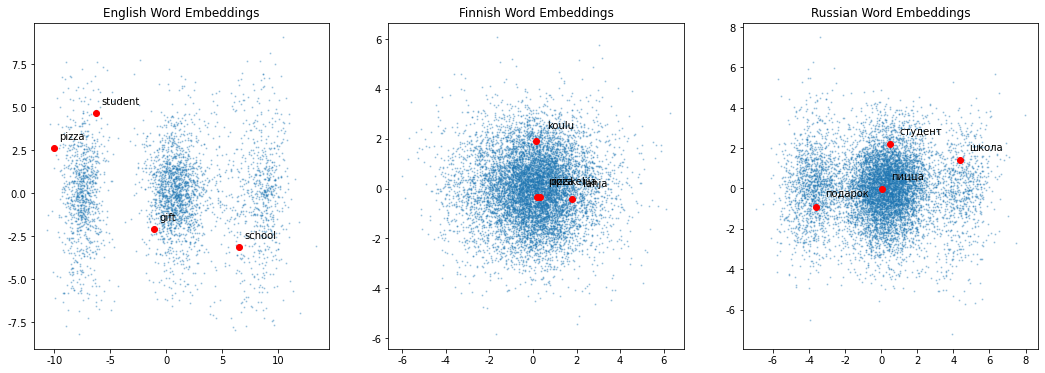

In [266]:
# obtain the word embeddings from the trained models for each language from the word_embed layer
languages = ['English', 'Finnish', 'Russian']
models = [word2vec_english, word2vec_finnish, word2vec_russian]
vocabs = [vocabulary_english, vocabulary_finnish, vocabulary_russian]
words = {'English': ['school', 'pizza', 'gift', 'student'],
         'Russian': ['школа', 'пицца', 'подарок', 'студент'], 
         'Finnish': ['koulu', 'pizza','lahja', 'opiskelija']}
# PCA is not deterministic when it comes to axis orientation. 
# signs of the principal components can be flipped in different runs of PCA
np.random.seed(42)
torch.manual_seed(42)
pca = PCA(n_components=2)

def compare_words(embeddings, vocab, word1, word2):
    idx1 = vocab[word1]
    idx2 = vocab[word2]
    similarity = cosine_similarity(embeddings[idx1].reshape(1, -1), embeddings[idx2].reshape(1, -1))
    return similarity[0][0]

plt.figure(figsize=(18, 6))
for i, (language, model, vocab) in enumerate(zip(languages, models, vocabs)):
    word_embed = model.word_embed.weight.detach().numpy()
    word_embed_reduced = pca.fit_transform(word_embed)
    plt.subplot(1, 3, i + 1)
    plt.scatter(word_embed_reduced[:, 0], word_embed_reduced[:, 1], alpha=0.3, s=1)
    plt.title(f'{language} Word Embeddings')

    for word in words[language]:
        if word in vocab:
            idx = vocab[word]
            plt.scatter(word_embed_reduced[idx, 0], word_embed_reduced[idx, 1], color='red')
            plt.annotate(word, (word_embed_reduced[idx, 0]+0.5, word_embed_reduced[idx, 1]+0.5))
    
    similarity = compare_words(word_embed, vocab, words[language][1], words[language][3])
    print(f'  Cosine similarity between "{words[language][1]}" and "{words[language][3]}": {similarity}')
plt.show()


Perform a clustering method on the words and investigate the quality of the clusters.

To further investigate the quality of the clusters, we can examine the words that belong to each cluster. 
We will print the top 5 most frequent words for each cluster in each language:

English
Cluster 0: win, blarney, welcome, adherents, showed
Cluster 1: sorry, unless, doctor, outside, visit
Cluster 2: wants, inside, stray, thirty, fix
Finnish
Cluster 0: vaipui, mukavalta, syntyi, puhui, meni
Cluster 1: tarjouksia, -sitten, kookas, kuolleita, varrella
Cluster 2: auttaa, suuteli, molemmat, maria, jäädä
Russian
Cluster 0: бельё, вдоль, монашки, дерьмо, недостатков
Cluster 1: темных, ненавижу, едим, протянут, тайский
Cluster 2: пытались, знаешь, хотите, телевизор, сказал


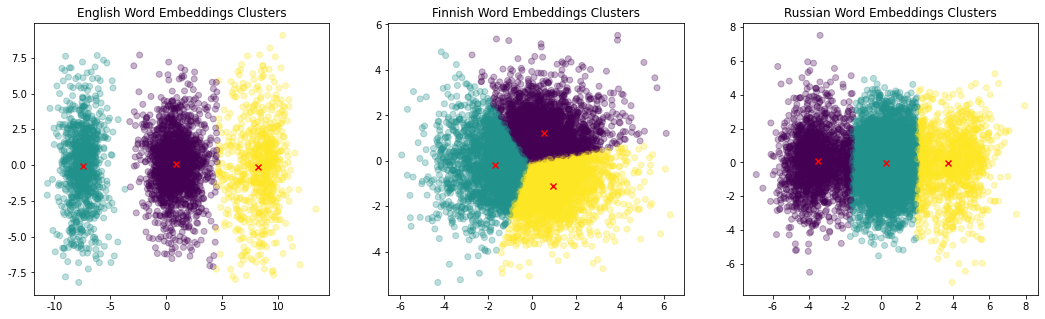

In [270]:
def print_top_words_for_clusters(embedding, kmeans, vocab, n_top_words=5):
    clusters = {i: [] for i in range(n_clusters)}
    id2word = {v: k for k, v in vocab.items()}
    
    for i, label in enumerate(kmeans.labels_):
        clusters[label].append(id2word[i])

    for cluster_id, words in clusters.items():
        words = sorted(words, key=lambda x: embedding[vocab[x], 0], reverse=True)[:n_top_words]
        print(f"Cluster {cluster_id}: {', '.join(words)}")

# Number of clusters
n_clusters = 3
kmean = KMeans(n_clusters=n_clusters)
plt.figure(figsize=(18, 5))
for i, (language, model, vocab) in enumerate(zip(languages, models, vocabs)): 
    word_embed = model.word_embed.weight.detach().numpy()
    word_embed_reduced = pca.fit_transform(word_embed)
    model = kmean.fit(word_embed_reduced)
    plt.subplot(1, 3, i + 1)
    plt.scatter(word_embed_reduced[:, 0], word_embed_reduced[:, 1], c=model.labels_, cmap='viridis', alpha=0.3)
    plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c='red', marker='x')
    plt.title(f'{language} Word Embeddings Clusters')
    print(language)
    print_top_words_for_clusters(word_embed_reduced, model, vocab)
plt.show()

### 8) Short Answer
In your own words (2-3 sentences), explain what the model learns. Make sure your explanation applies to all 3 of the word2vec models in this homework. 

Write your answer below this.



### 9) Connect our corpora
Develop a method to connect our corpora. 

Suggestions:
1) Retrain a word2vec model that simultaneously embeds both english and russian words

2) Create a mapping between the two embeddings generated

3) Identify some idioms in one language within our embedded corpora and assess how they manifest in the embedding of another language.  

Feel free to try some different things out here. The end result should be a figure with a short caption. 

In [ ]:
### type code here ###

Retrain a word2vec model that simultaneously embeds both English and Russian words:

First, we will create a combined vocabulary for English and Russian. Then, we will generate the training data for this combined vocabulary.

In [279]:
# Combine English and Russian vocabulary

vocab_engrus = {word: idx for idx, word in zip(range(len(vocabulary_english)+len(vocabulary_russian)), {**vocabulary_english, **vocabulary_russian}.keys())}
token_counts_engrus = {**token_counts_english, **token_counts_russian}
# Generate training data for combined vocabulary
x_combined, y_combined = generate_training_data(pp_eng2rus + pp_rus2eng, [], vocab_engrus, window_size)

# Generate negative samples
pairs_combined, labels_combined = generate_negative_samples(x_combined, y_combined, m, vocab_engrus, token_counts_engrus)

# Train the model with combined vocabulary
word2vec_combined = train_word2vec(pairs_combined, labels_combined, vocab_engrus)

Epoch 1/50, Loss: 1.5219127107127206
Epoch 2/50, Loss: 0.4122111908545855
Epoch 3/50, Loss: 0.36574729941796946
Epoch 4/50, Loss: 0.35120987822497585
Epoch 5/50, Loss: 0.33341010899308243
Epoch 6/50, Loss: 0.32178913041991064
Epoch 7/50, Loss: 0.3144521526678881
Epoch 8/50, Loss: 0.30493356001204364
Epoch 9/50, Loss: 0.30220360832910514
Epoch 10/50, Loss: 0.2979997501158016
Epoch 11/50, Loss: 0.29476033974451676
Epoch 12/50, Loss: 0.2916563468865978
Epoch 13/50, Loss: 0.2896054070379066
Epoch 14/50, Loss: 0.28752861323340656
Epoch 15/50, Loss: 0.285849679843051
Epoch 16/50, Loss: 0.28293878502909287
Epoch 17/50, Loss: 0.2840152543540794
Epoch 18/50, Loss: 0.2823571100896042
Epoch 19/50, Loss: 0.2820975610254412
Epoch 20/50, Loss: 0.2824070874999787
Epoch 21/50, Loss: 0.2803927325907991
Epoch 22/50, Loss: 0.27983994664024736
Epoch 23/50, Loss: 0.2795048177232992
Epoch 24/50, Loss: 0.28092375832783095
Epoch 25/50, Loss: 0.2778242371950836
Epoch 26/50, Loss: 0.2788451488036053
Epoch 27/50

In [280]:
# Save model
model_info = {
    'state_dict': word2vec_combined.state_dict(),
    'vocabulary': vocab_engrus,
    'embed_size': word2vec_combined.word_embed.embedding_dim,
}

torch.save(model_info, f'word2vec_combined.pth')


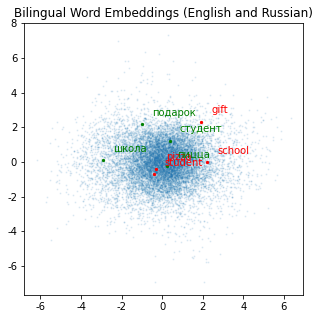

  Cosine similarity between "school" and "школа": -0.13037747144699097
  Cosine similarity between "pizza" and "пицца": 0.06786992400884628
  Cosine similarity between "gift" and "подарок": -0.12133821099996567
  Cosine similarity between "student" and "студент": -0.053466323763132095


In [295]:
colors = ['red', 'green']
words = {'english': ['school', 'pizza', 'gift', 'student'], 
        'russian': ['школа', 'пицца', 'подарок', 'студент']}
# PCA is not deterministic when it comes to axis orientation. 
# signs of the principal components can be flipped in different runs of PCA
np.random.seed(42)
torch.manual_seed(42)
pca = PCA(n_components=2)

word_embed = word2vec_combined.word_embed.weight.detach().numpy()
word_embed_reduced = pca.fit_transform(word_embed)

plt.figure(figsize=(5, 5))
plt.scatter(word_embed_reduced[:, 0], word_embed_reduced[:, 1], alpha=0.1, s=1)
plt.title(f'Bilingual Word Embeddings (English and Russian)')
 
for language, color in zip(words, colors):
    for word in words[language]:
        if word in vocab_engrus:
            idx = vocab_engrus[word]
            plt.scatter(word_embed_reduced[idx, 0], word_embed_reduced[idx, 1], color=color, s=5)
            plt.annotate(word, (word_embed_reduced[idx, 0]+0.5, word_embed_reduced[idx, 1]+0.5), color=color)

plt.show()

def compare_words(embeddings, vocab, word1, word2):
    idx1 = vocab[word1]
    idx2 = vocab[word2]
    similarity = cosine_similarity(embeddings[idx1].reshape(1, -1), embeddings[idx2].reshape(1, -1))
    return similarity[0][0]

for word1, word2 in zip(*words.values()):
    similarity = compare_words(word_embed, vocab_engrus, word1, word2)
    print(f'  Cosine similarity between "{word1}" and "{word2}": {similarity}')

Create a mapping between the two embeddings generated:
We can use linear transformations to find a mapping between the English and Russian word embeddings. A popular approach is using orthogonal Procrustes to find an optimal linear transformation. We'll use scipy's implementation for this task.

In [173]:

from scipy.linalg import orthogonal_procrustes

# Find the linear transformation using orthogonal Procrustes
R, _ = orthogonal_procrustes(word_embeddings_english, word_embeddings_russian[:3588])


Identify some idioms in one language within our embedded corpora and assess how they manifest in the embedding of another language:

First, let's choose a few idiomatic expressions or common phrases in English and their corresponding translations in Russian. Then, we will compare the similarity of the transformed embeddings.

In [180]:
idioms = [
    ("break ice", "лед"),
    ("weather", "духе"),
]

for english_idiom, russian_idiom in idioms:
    english_words = english_idiom.split()
    russian_words = russian_idiom.split()
    
    english_embeds = np.mean([word_embeddings_english[vocabulary_english[word]] for word in english_words], axis=0)
    russian_embeds = np.mean([word_embeddings_russian[vocabulary_russian[word]] for word in russian_words], axis=0)
    
    transformed_english_embeds = np.dot(english_embeds, R)

    similarity = np.dot(transformed_english_embeds, russian_embeds) / (np.linalg.norm(transformed_english_embeds) * np.linalg.norm(russian_embeds))
    print(f"Similarity between '{english_idiom}' and '{russian_idiom}': {similarity:.4f}")


Similarity between 'break ice' and 'лед': 0.0546


KeyError: 'духе'

This will show you the similarity between the idiomatic expressions in the two languages based on the transformed embeddings. Keep in mind that this method may not always give high similarity scores for idiomatic expressions, as their meaning can be context-dependent or figurative.